In [1]:
import numpy as np
import os
import tensorflow as tf
from IPython.display import clear_output, Image, display, HTML
from tensorflow.contrib.layers import variance_scaling_initializer
from tensorflow.contrib.layers import fully_connected
from tensorflow.contrib.data import Dataset, Iterator
from sklearn.metrics import f1_score, classification_report
import datetime
import pickle
from nltk.tokenize import TweetTokenizer
import pandas as pd
import re
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
###### Do not modify here ###### 
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = graph_def
    #strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))
###### Do not modify  here ######

###### Do not modify here ###### 

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)



## Data Preparing

In [2]:
tknzr = TweetTokenizer()

def filter_tweet(tweet, token = tknzr):
    try:
        tweet = re.sub('https?:\/\/\S+','URLTOK',tweet.lower().strip()) # url
        tweet = re.sub('@(?:[a-zA-Z]+|[0-9 \/]+)', '<M>', tweet) # mention
        tweet = re.sub('#(?:[a-zA-Z]+|[0-9 \/]+)', '<H>', tweet) # hashtag
        tweet = re.sub('(\:|\=)(?:\)|\-|\(|D| )+', '', tweet) # emoticon
    except:
        print(tweet)
        return [0]
    return token.tokenize(tweet) # return tokenized



### Load positive data

#### Negative Tweets

In [3]:
with open('data/distance_supervised/sad') as f:
    sad_tweet = [filter_tweet(line) for line in f.readlines()]

with open('data/distance_supervised/distance_supervised_tweets_corrected') as f:
    sad_tweet += [filter_tweet(line.split('\t')[3]) for line in f.readlines()]

with open('data/distance_supervised/distance_supervised_tweets_2_corrected') as f:
    sad_tweet += [filter_tweet(line.split('\t')[3]) for line in f.readlines()]

with open('data/distance_supervised/distance_supervised_tweets_3_corrected') as f:
    sad_tweet += [filter_tweet(line.split('\t')[3]) for line in f.readlines()]
print(len(sad_tweet))


1252941


#### Positive Tweets

In [5]:
with open('data/distance_supervised/smile') as f:
    smile_tweet = [filter_tweet(line) for line in f.readlines()][:len(sad_tweet)]
len(smile_tweet)

1252941

In [6]:
# size filter
max_length = 60

In [7]:


sad_tweet = list(filter(lambda tweet: len(tweet) <= max_length, sad_tweet))
print(len(sad_tweet))
smile_tweet = list(filter(lambda tweet: len(tweet) <= max_length, smile_tweet))
print(len(smile_tweet))

1252345
1252910


### Build Dictionary

In [9]:
from collections import defaultdict
vocabulary_dict = {}
word_index = 2 # keep the 0 for no more word, 1 for not found word

for tweet in smile_tweet+sad_tweet:
    for word in tweet:
        if word not in vocabulary_dict:
            vocabulary_dict[word] = word_index
            word_index +=1

In [10]:
vocabulary_dict['<m>'] = vocabulary_dict.get('<M>')
vocabulary_dict['<h>'] = vocabulary_dict.get('<h>')
vocabulary_dict['urltok'] = vocabulary_dict.get('URLTOK')
len(vocabulary_dict)

496893

In [11]:
print(vocabulary_dict.get('URLTOK'))
print(vocabulary_dict.get('urltok'))
print(vocabulary_dict.get('<M>'))
print(vocabulary_dict.get('<H>'))

349886
349886
349899
172


In [12]:
# transform the tweet sentence to numerical representation
def word_transform(tweet_set, max_length = 60):
    set_array = []
    for tweet in tweet_set:
        tweet_array = [0] * max_length
        for i, word in enumerate(tweet):
            if i == 60: break # remove the words after 60th
            if vocabulary_dict.get(word):
                tweet_array[i] = vocabulary_dict[word]
            else:
                tweet_array[i] = 1 # assign not found words to 1
        set_array.append(tweet_array)
    return np.array(set_array)

In [13]:
sad_array = word_transform(sad_tweet, max_length = max_length)
print(sad_array.shape)
smile_array = word_transform(smile_tweet, max_length = max_length)
print(smile_array.shape)

(1252345, 60)
(1252910, 60)


In [14]:
smile_array[0]

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 20, 23,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0])

In [15]:
sad_array[0]

array([327, 403,  75, 198,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0])

In [31]:
total_tweets = np.concatenate((smile_array[:sad_array.shape[0]], sad_array), axis=0)
total_labels = np.concatenate((np.zeros(sad_array.shape[0]), np.ones(sad_array.shape[0])+1), axis=0)

## Prepare Training + Testing Data

In [32]:
# from sklearn.model_selection import ShuffleSplit
# rs = ShuffleSplit(n_splits=1, test_size=.1, random_state=0)

# senti_train = en_train['label'].as_matrix()
# senti_test  = en_test['label'].as_matrix()

# for train_index, test_index in rs.split(senti):
#     X_train = tweets[train_index]
#     y_train = senti[train_index]

#     X_test = tweets[test_index]
#     y_test = senti[test_index]
# X_train.shape

from sklearn.utils import shuffle
X_train, y_train = shuffle(total_tweets, total_labels, random_state=8)

y_train

array([ 0.,  2.,  2., ...,  0.,  2.,  2.])

# Load Pretrain Word2Vec Model (#DIM 200)

In [18]:
# # Load pre train Word2vec
wb_matrix = np.load("data/embed_tweets_en_200M_200D/embedding_matrix.npy")
print(wb_matrix.shape)
vocabulary_dict_ = pickle.load(open("data/embed_tweets_en_200M_200D/vocabulary.pickle", "rb"))
print(len(vocabulary_dict_))

(1859185, 200)
1859184


In [19]:
# Load pre train Word2vec from glove
# wb_matrix = np.zeros((400001,200), np.float32)
# vocabulary_dict_ = {}
# # w2v
# with open('data/embedding/glove.6B.200d.txt') as f:
#     for i, line in enumerate(f.readlines()):
#         line_split = line.split()
#         vocabulary_dict_[line_split[0]] = i+1
#         wb_matrix[i+1] = np.array(line_split[1:])
# wb_matrix = np.load("data/embedding/glove6B_200.npy")
# print(wb_matrix.shape)
# vocabulary_dict_ = pickle.load(open("data/embedding/glove6B_200.pickle", "rb"))
# print(len(vocabulary_dict_))

In [20]:
print(vocabulary_dict.get('URLTOK'))
print(vocabulary_dict_.get('URLTOK'))

349886
(6, 49017056)


In [23]:
 # initial matrix with random uniform
initW = np.random.uniform(-0.25,0.25,(len(vocabulary_dict)+2, wb_matrix.shape[1])) # +2 is for 0th row, which is no more sentence, 1th for not found words
# load any vectors from the word2vec
for word, index in vocabulary_dict.items():
#     print(word)
#     print(index)
    try:
        idx = vocabulary_dict_.get(word)[0]
    except:
        continue
    
    if idx != 0 and idx is not None:
        initW[index] = wb_matrix[idx]

initW[0] = np.zeros((1,wb_matrix.shape[1])) # assign no more word's vector to all zeros
initW.shape

(496895, 200)

# Distance Supervised Learning

In [33]:
n_input = max_length
n_output = 3
learning_rate = 1

embedding_size = initW.shape[1]
filter_sizes = [4,3]
num_filters = 200
pooling_size = 4
pooling_strides = 2
epochs_num = 20
batch_size = 128

In [34]:
def data_iterator():
    """ A simple data iterator """
    batch_idx = 0
    while True:
        for batch_idx in range(0, len(X_train), batch_size):
            trains_batch = X_train[batch_idx:batch_idx+batch_size]
            labels_batch = y_train[batch_idx:batch_idx+batch_size]
            yield trains_batch, labels_batch


iter_ = data_iterator()

In [35]:
reset_graph()

X = tf.placeholder(tf.int32, shape = (None, n_input), name = "Input_X")
y = tf.placeholder(tf.int32, shape = (None), name = "Y")
# mode = tf.placeholder(tf.bool, name = "Mode")

# Load Embedding Model
with tf.device('/cpu:0'), tf.name_scope("embedding"):
    word2vec = tf.Variable(tf.constant(0.0, shape = initW.shape),
                    trainable=True, name="word2vec") # trainable=False, means not update these embeddings

embedded_chars = tf.nn.embedding_lookup(word2vec, X)
embedded_chars_expanded = tf.expand_dims(embedded_chars, -1) # ex: convert [[1,2]] to [[1],[2]], that is shape (2,) to (2,1)

# 1st convolution layer
conv1 = tf.layers.conv2d(embedded_chars_expanded, 
                         filters = num_filters, 
                         kernel_size = (filter_sizes[0], initW.shape[1]),
                         strides = (1,1), 
#                          padding="same",
                         kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                         
                         activation = tf.nn.relu,
                         name="Convolution_1st"
                        )

pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[4, 1], strides=2)

# 2nd convolution layer
conv2 = tf.layers.conv2d(pool1, 
                         filters = num_filters, 
                         kernel_size = (filter_sizes[1], 1),
                         strides = (1,1), 
                         padding="same",
                         kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                         activation = tf.nn.relu,
                         name="Convolution_2nd"
                        )

pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[27, 1], strides=1)

# Dense Layer, Combine all the pooled features
pool2_flat = tf.reshape(pool2, [-1, num_filters])

dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu, name = "Fully_connect")
# dense = tf.layers.dropout(inputs = dense, rate = 0.3, training = mode)

# Logits Layer
logits = tf.layers.dense(inputs=dense, 
                         units=n_output, 
#                          activation=tf.nn.softmax, 
#                          kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                         name = "Softmax")

# Define Loss Function
cross_entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits, name="Cross_Entropy"))

# Define Training Process
train_step = tf.train.AdadeltaOptimizer(learning_rate, epsilon=1e-6).minimize(cross_entropy)

# Define Accuracy
predicted_class = tf.argmax(logits,1, output_type=tf.int32)
correct_predict = tf.equal(y, predicted_class) # [True, False ..., True]
accuracy = tf.reduce_mean(tf.cast(correct_predict, tf.float32)) # [True, False ..., True] --> [1,0,...,1]


In [87]:
# prepare the training batch
# train_data = tf.contrib.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size).repeat()
# train_iterator = train_data.make_one_shot_iterator() # Create an iterator to go through the training data
# train_next_batch = train_iterator.get_next()

In [36]:
round_of_epochs = int(X_train.shape[0]/batch_size)
print(round_of_epochs)

saver = tf.train.Saver() # to store the model

with tf.Session() as sess:
    # Initialize all variables
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    
    sess.run(word2vec.assign(initW))# Assign the pretrain word2vec
    for i in range(epochs_num):
        for _ in range(round_of_epochs):
#             train, label = sess.run(train_next_batch) # Get the mini-batch data sample
            train, label = next(iter_)
            sess.run(train_step, feed_dict={X:train, y:label}) # Feed the features, labe, training_mode  to network to train
           
        
    distance_supervised_embeddings = sess.run(word2vec)
    

19567


## Distance Supervised Learning Comparsion

In [37]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


In [38]:
def draw_plot(words, matrix, v_dic, nbest=15):
    word_vectors = []
    for word in words:
        index = v_dic[word]
        word_vectors.append(matrix[index])  
    pca = PCA(n_components=2)  
    pca.fit(word_vectors)
    X = pca.transform(word_vectors)
    
    xs = X[:, 0]
    ys = X[:, 1]

    # draw
    plt.figure(figsize=(12,8))
    plt.scatter(xs, ys, marker = 'o')
    for i, w in enumerate(words):
        plt.annotate(w, (xs[i], ys[i]))

    plt.show()

Word2vec with distance supervised learning

Before


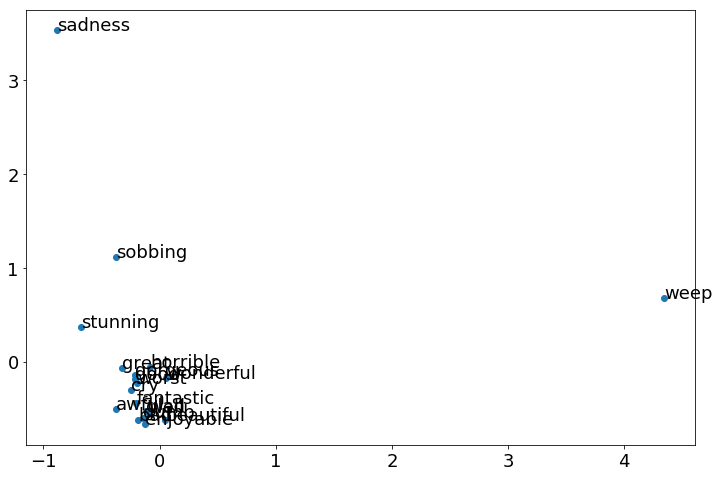

After


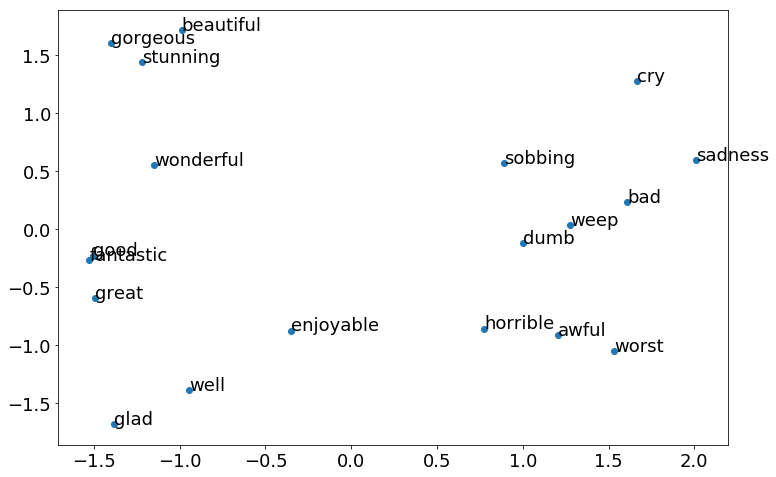

In [39]:
words = ['sadness', 'sobbing', 'cry', 'weep', 'horrible', 'worst', 'awful', 'enjoyable', 'wonderful',
         'bad', 'fantastic', 'great', 'good', 'beautiful', 'stunning','gorgeous','glad','well','dumb']

plt.rcParams['font.size'] = 18

print("Word2vec with distance supervised learning\n")
print("Before")
draw_plot(words, wb_matrix, vocabulary_dict)
print("After")
draw_plot(words, distance_supervised_embeddings, vocabulary_dict)

### Dump model

In [68]:
distance_supervised_embeddings[0] = 0 # reassign the no more word to all 0

np.save('data/embedding/distance_supervised_2M_200', distance_supervised_embeddings)
with open('data/embedding/distance_supervised_2M_200.pickle', 'wb') as f:
    pickle.dump(vocabulary_dict,f)

# np.save('data/embedding/distance_supervised_Glove_200', distance_supervised_embeddings)
# with open('data/embedding/distance_supervised_Glove_200.pickle', 'wb') as f:
#     pickle.dump(vocabulary_dict,f)

In [50]:
del wb_matrix, vocabulary_dict_, X_train, y_train, smile_array, smile_tweet, sad_array, sad_tweet

### Load model

In [69]:
# Load pre train Word2vec
distance_supervised_embeddings = np.load("data/embedding/distance_supervised_2M_200.npy")
print(distance_supervised_embeddings.shape)
# distance_supervised_embeddings_glove = np.load("data/embedding/distance_supervised_Glove_200.npy")
# print(distance_supervised_embeddings_glove.shape)

vocabulary_dict = pickle.load(open("data/embedding/distance_supervised_2M_200.pickle", "rb"))
print(len(vocabulary_dict))



(496895, 200)
496893


In [4]:
# words_num, dims_num = distance_supervised_embeddings.shape
# multi_embeddings = np.concatenate((distance_supervised_embeddings.reshape((words_num, dims_num, 1)), distance_supervised_embeddings_glove.reshape((words_num, dims_num, 1))), axis=2)
# multi_embeddings.shape

(496894, 200, 2)

# Supervised Learning

In [40]:
def emotion2label(emo):
    if emo =='joy':            return 0
    elif emo =='anticipation': return 1
    elif emo =='trust':        return 2
    elif emo =='surprise':     return 3
    elif emo =='sadness':      return 4
    elif emo =='fear':         return 5
    elif emo =='anger':        return 6
    elif emo =='disgust':      return 7

In [41]:
# Load Training data
en_train = pd.read_csv('data/emo/Train/train.tsv', delimiter='\t', names=["emotion", "tweet"])
en_train.head()



,emotion,tweet
0,anticipation,<M>: <H> <H> <H> <H> <H> <H> <M> ... You DTM. ...
1,anger,stop posting every damn thing you do on instag...
2,trust,<H> youll never meet justin bieber. hell never...
3,anticipation,<H> &amp; count down the days until May! <H> <...
4,surprise,<M> Holme upon Spalding moor won rock challeng...


In [42]:
en_train.groupby('emotion').count()

,tweet
emotion,
anger,332416
anticipation,86100
disgust,17966
fear,352271
joy,351119
sadness,439736
surprise,165751
trust,220511


In [43]:

# Load Testing data
en_test = pd.read_csv('data/emo/Test/test.tsv', delimiter='\t',names=["tweet","emotion", "emotion2", "emotion3"])
en_test.head()

,tweet,emotion,emotion2,emotion3
0,#championsleague i am cmng to watch you...all ...,joy,anticipation,trust
1,#mufc wages up19% in13/14 season with #dimaria...,anticipation,fear,NaN
2,#sterlings getting some great experience here....,joy,trust,anticipation
3,1 more week then it's block 208 kop grandstand...,anticipation,joy,trust
4,1 week from today! the @championsleague return...,anticipation,joy,trust


In [44]:
en_train['label'] = en_train['emotion'].map(emotion2label)
en_train.head()


,emotion,tweet,label
0,anticipation,<M>: <H> <H> <H> <H> <H> <H> <M> ... You DTM. ...,1
1,anger,stop posting every damn thing you do on instag...,6
2,trust,<H> youll never meet justin bieber. hell never...,2
3,anticipation,<H> &amp; count down the days until May! <H> <...,1
4,surprise,<M> Holme upon Spalding moor won rock challeng...,3


In [45]:

en_test['label'] = en_test['emotion'].map(emotion2label).fillna(-1).astype('int')
en_test['label2'] = en_test['emotion2'].map(emotion2label).fillna(-1).astype('int')
en_test['label3'] = en_test['emotion3'].map(emotion2label).fillna(-1).astype('int')
en_test.head()

,tweet,emotion,emotion2,emotion3,label,label2,label3
0,#championsleague i am cmng to watch you...all ...,joy,anticipation,trust,0,1,2
1,#mufc wages up19% in13/14 season with #dimaria...,anticipation,fear,NaN,1,5,-1
2,#sterlings getting some great experience here....,joy,trust,anticipation,0,2,1
3,1 more week then it's block 208 kop grandstand...,anticipation,joy,trust,1,0,2
4,1 week from today! the @championsleague return...,anticipation,joy,trust,1,0,2


In [46]:
en_test.groupby('emotion').count()

,tweet,emotion2,emotion3,label,label2,label3
emotion,,,,,,
anger,223,194,57,223,223,223
anticipation,272,146,61,272,272,272
disgust,183,118,91,183,183,183
fear,119,99,43,119,119,119
joy,591,356,93,591,591,591
sadness,218,176,64,218,218,218
surprise,246,187,49,246,246,246
trust,102,94,59,102,102,102


In [47]:
%%time
train_tweet = [filter_tweet(tweet) for tweet in en_train['tweet']]
test_tweet = [filter_tweet(tweet) for tweet in en_test['tweet']]


print(len(train_tweet))
print(len(test_tweet))

1965870
1954
CPU times: user 1min 8s, sys: 576 ms, total: 1min 9s
Wall time: 1min 8s


In [48]:
%%time
max_length = 60
tweets_train_all = word_transform(train_tweet, max_length = max_length)
print(tweets_train_all.shape)
tweets_test = word_transform(test_tweet, max_length = max_length)
print(tweets_test.shape)

senti_train_all = en_train['label'].as_matrix()
senti_test  = en_test['label'].as_matrix()
senti_test2  = en_test['label2'].as_matrix()
senti_test3  = en_test['label3'].as_matrix()

(1965870, 60)
(1954, 60)
CPU times: user 15.6 s, sys: 256 ms, total: 15.9 s
Wall time: 15.8 s


In [94]:
del train_tweet, test_tweet 

## Word Energy Vector

In [54]:
import sys
sys.path.append('./library/English_to_IPA/src/')
import conversion as cv
from joblib import Parallel, delayed
from scipy.sparse import vstack

In [55]:
print(cv.convert('some'))

('s ah1 m', 'sʌ m')


In [56]:
eSPEDictV2 = dict()
with open('./library/eSPEPhonologicalTableV2.txt') as openFile:
    for line in openFile.readlines():
        line = line.strip().split('\t')
        eSPEDictV2[line[0]] = np.array([eval(x) for x in line[1:]])

In [57]:
### (8 classes + 1 class:#(words))
def getWordScore(word):
    score = np.zeros((8,))
    # 字典裡找不到這個字
    if word == "<m>" or word =="<h>" or word == "urltok": return 0
    try:
        cmu, ipa = cv.convert(word)
    except:
        return 0
    ipa = re.sub('[ˌ\ˈ ]' ,'' ,ipa)
    if '*' in ipa:
        return 0
    i = 0
    while i < len(ipa):
        # 最後一個音標
        if i == len(ipa)-1:
            sym = ipa[i]
            if sym in eSPEDictV2:
                score += eSPEDictV2[sym]
            i += 1
        # 非最後一個音標
        else:
            try:
                sym = ipa[i] + ipa[i+1]
                score += eSPEDictV2[sym]
                i += 2
            except KeyError:
                sym = ipa[i]
                if sym in eSPEDictV2:
                    score += eSPEDictV2.get(sym)
                i += 1
    return score

def getTweetScoreV2(words):
    wordCount = 0.0
    score = np.zeros((8,))
    for word in words:
        # 字典裡找不到這個字
        if word == "<m>" or word =="<h>" or word == "urltok": continue
        try:
#             print(word)
            cmu, ipa = cv.convert(word)
        except:
            continue
        ipa = re.sub('[ˌ\ˈ ]' ,'' ,ipa)
        if '*' in ipa:
            continue
        wordCount += 1
        i = 0
        while i < len(ipa):
            # 最後一個音標
            if i == len(ipa)-1:
                sym = ipa[i]
                if sym in eSPEDictV2:
                    score += eSPEDictV2[sym]
                i += 1
            # 非最後一個音標
            else:
                try:
                    sym = ipa[i] + ipa[i+1]
                    score += eSPEDictV2[sym]
                    i += 2
                except KeyError:
                    sym = ipa[i]
                    if sym in eSPEDictV2:
                        score += eSPEDictV2.get(sym)
                    i += 1
    if wordCount != 0:
        return score/wordCount
    else:
        return 0
    
def getPhonScoreV2(tweets_list):
    phon_feature = np.zeros((len(tweets_list),8), np.float32)
#     phon_feature = getTweetScoreV2(tweets_list[0])
    for i, tweets in enumerate(tweets_list):
        phon_feature[i] = getTweetScoreV2(tweets)
    return phon_feature
    
def transform_parrallel(documents, n_jobs=1, n_chunk=500):
    chunks = [documents[i:i + n_chunk] for i in range(0, len(documents), n_chunk)]
    res = Parallel(n_jobs=n_jobs, verbose=0)(delayed(getPhonScoreV2)(chunk) for chunk in chunks)
    return np.vstack(res)


### Word Energy as Input

In [58]:
getTweetScoreV2(train_tweet[0])

array([ 6.        ,  2.        ,  3.66666667,  1.        ,  1.33333333,
        1.        ,  1.        ,  1.33333333])

In [116]:
%%time

# tweets_train_phon = transform_parrallel(train_tweet, n_jobs=8)
tweets_train_phon = np.load(("data/tweets_energy.npy"))
print(tweets_train_phon.shape)
tweets_test_phon = transform_parrallel(test_tweet, n_jobs=8)
print(tweets_test_phon.shape)

(1965870, 8)
(1954, 8)
CPU times: user 652 ms, sys: 128 ms, total: 780 ms
Wall time: 1.28 s


In [115]:
# keep the tweets_train_phon matrix
# np.save('data/tweets_energy', tweets_train_phon)

### Word Energy Vector to look up

In [113]:
getWordScore('No')

array([ 3.,  3.,  1.,  1.,  1.,  1.,  1.,  1.])

In [60]:
word_energy_vec = np.random.uniform(-0.25,0.25,(len(vocabulary_dict)+2, 8)) # +2 is for 0th row, which is no more sentence, 1th for not found words. 8 for 8 categories of phonology feature
for word, idx in vocabulary_dict.items():
    word_score = getWordScore(word)
    if type(word_score) != int:
        word_energy_vec[idx] = word_score
        

word_energy_vec.shape

(496895, 8)

### Standardize the word energy matrix

In [71]:
from sklearn import preprocessing

In [74]:
scaler = preprocessing.StandardScaler().fit(word_energy_vec)
word_energy_vec[2]

array([ 4.,  1.,  5.,  0.,  0.,  1.,  1.,  1.])

In [76]:
word_energy_vec = scaler.transform(word_energy_vec)
word_energy_vec[2]

array([ 1.29277669,  0.38031303,  0.49624015, -0.3154027 , -0.26038348,
        0.82644532,  2.10956207,  0.72176718])

In [78]:
word_energy_vec[0] = 0 # set no more word to 0

word_energy_vec.shape

(496895, 8)

## Pattern Vector

### Train Validation Split 

In [79]:
from sklearn.model_selection import train_test_split

In [83]:
tweets_train, tweets_valid, senti_train, senti_valid = train_test_split(tweets_train_all, 
                                                                        senti_train_all, 
                                                                        test_size=0.1, 
                                                                        random_state=42)
print(tweets_train.shape)
print(tweets_valid.shape)

(1769283, 60)
(196587, 60)


### Build Model

In [18]:
import os
# os.makedirs("./model")

In [122]:
n_input = max_length
n_output = 8
learning_rate = 1

embedding_size = distance_supervised_embeddings.shape[1]
filter_sizes = [2,3]
num_filters = 300
pooling_size = 3
pooling_strides = 2
epochs_num = 25
batch_size = 64

### Pure Word Embedding

In [123]:
reset_graph()

X = tf.placeholder(tf.int32, shape = (None, n_input), name = "Input_X")
y = tf.placeholder(tf.int32, shape = (None), name = "Y")
mode = tf.placeholder(tf.bool, name = "Mode")

# Load Embedding Model
with tf.device('/cpu:0'), tf.name_scope("embedding"):
    word2vec = tf.Variable(tf.constant(0.0, shape = distance_supervised_embeddings.shape),
                    trainable=False, name="word2vec") # trainable=False, means not update these embeddings

embedded_chars = tf.nn.embedding_lookup(word2vec, X)
embedded_chars_expanded = tf.expand_dims(embedded_chars, -1) # ex: convert [[1,2]] to [[1],[2]], that is shape (2,) to (2,1)

# 1st convolution layer
conv1 = tf.layers.conv2d(embedded_chars_expanded, 
                         filters = num_filters, 
                         kernel_size = (filter_sizes[0], distance_supervised_embeddings.shape[1]),
                         strides = (1,1), 
#                          padding="same",
                         kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                         
                         activation = tf.nn.relu,
                         name="Convolution_1st"
                        )

pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[pooling_size, 1], strides=pooling_strides)

# 2nd convolution layer
conv2 = tf.layers.conv2d(pool1, 
                         filters = num_filters, 
                         kernel_size = (filter_sizes[1], 1),
                         strides = (1,1), 
                         padding="same",
                         kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                         activation = tf.nn.relu,
                         name="Convolution_2nd"
                        )
print(conv2.shape)
pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[29, 1], strides=1)

# Dense Layer, Combine all the pooled features
pool2_flat = tf.reshape(pool2, [-1, num_filters])

dense = tf.layers.dropout(inputs = pool2_flat, rate = 0.3, training = mode, name="Dropout")

dense = tf.layers.dense(inputs=dense, units=512, activation=tf.nn.relu, name = "Fully_connect")


# Logits Layer
logits = tf.layers.dense(inputs=dense, 
                         units=n_output, 
#                          activation=tf.nn.softmax, 
#                          kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                         name = "Logits")

# Define Loss Function
cross_entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits, name="Cross_Entropy"))

# Define Training Process
train_step = tf.train.AdadeltaOptimizer(learning_rate, epsilon=1e-6).minimize(cross_entropy)

# Define Accuracy
predicted_class = tf.argmax(logits,1, output_type=tf.int32)
correct_predict = tf.equal(y, predicted_class) # [True, False ..., True]
accuracy = tf.reduce_mean(tf.cast(correct_predict, tf.float32)) # [True, False ..., True] --> [1,0,...,1]


(?, 29, 1, 300)


### Word embedding + Word Energy Vec

In [ ]:
reset_graph()

X = tf.placeholder(tf.int32, shape = (None, n_input), name = "Input_X")
y = tf.placeholder(tf.int32, shape = (None), name = "Y")
mode = tf.placeholder(tf.bool, name = "Mode")

# Load Embedding Model
with tf.device('/cpu:0'):
    word2vec = tf.Variable(tf.constant(0.0, shape = distance_supervised_embeddings.shape),
                           trainable=False, name="word2Vec_twitter") # trainable=False, means not update these embeddings
    wordEnergyVec = tf.Variable(tf.constant(0.0, shape = word_energy_vec.shape),
                           trainable=False, name="word_Energy_Vec") # trainable=False, means not update these embeddings
    




# with tf.name_scope("Word_Level_Convolution"):
embedded_chars = tf.nn.embedding_lookup(word2vec, X)
embedded_chars_expanded = tf.expand_dims(embedded_chars, -1) # ex: convert [[1,2]] to [[1],[2]], that is shape (2,) to (2,1)
print(embedded_chars_expanded.shape)
# 1st convolution layer
conv1 = tf.layers.conv2d(embedded_chars_expanded, 
                         filters = num_filters, 
                         kernel_size = (filter_sizes[0], distance_supervised_embeddings.shape[1]),
                         strides = (1,1), 
#                          padding="same",
                         kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),

                         activation = tf.nn.relu,
                         name="Convolution_1st"
                        )

pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[pooling_size, 1], strides=pooling_strides)

# 2nd convolution layer
conv2 = tf.layers.conv2d(pool1, 
                         filters = num_filters, 
                         kernel_size = (filter_sizes[1], 1),
                         strides = (1,1), 
                         padding="same",
                         kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                         activation = tf.nn.relu,
                         name="Convolution_2nd"
                        )
print(conv2.shape)
pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[29, 1], strides=1)

# with tf.name_scope("Energy_Level_Convolution"):
energy_chars = tf.nn.embedding_lookup(wordEnergyVec, X)
energy_chars_expanded = tf.expand_dims(energy_chars, -1) # ex: convert [[1,2]] to [[1],[2]], that is shape (2,) to (2,1)
print(energy_chars_expanded.shape)
# 1st convolution layer
energy_conv1 = tf.layers.conv2d(energy_chars_expanded, 
                         filters = num_filters, 
                         kernel_size = (filter_sizes[0], word_energy_vec.shape[1]),
                         strides = (1,1), 
#                          padding="same",
                         kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                         activation = tf.nn.relu,
                         name="Energy_Convolution_1st"
                        )

energy_pool1 = tf.layers.max_pooling2d(inputs=energy_conv1, pool_size=[pooling_size, 1], strides=pooling_strides)


# 2nd convolution layer
energy_conv2 = tf.layers.conv2d(energy_pool1, 
                         filters = num_filters, 
                         kernel_size = (filter_sizes[1], 1),
                         strides = (1,1), 
                         padding="same",
                         kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                         activation = tf.nn.relu,
                         name="Energy_Convolution_2nd"
                        )
print(energy_conv2.shape)
energy_pool2 = tf.layers.max_pooling2d(inputs=energy_conv2, pool_size=[29, 1], strides=1)
    
# Dense Layer, Combine all the pooled features
conv_concat = tf.concat([pool2, energy_pool2], 1)
print(conv_concat.shape)

conv_concat = tf.reshape(conv_concat, [-1, 2*num_filters])

print(conv_concat.shape)

dense = tf.layers.dropout(inputs = conv_concat, rate = 0.3, training = mode, name="Dropout")

dense = tf.layers.dense(inputs=dense, units=512, activation=tf.nn.relu, name = "Fully_connect")

# dense = tf.layers.dropout(inputs = dense, rate = 0.3, training = mode, name="Dropout_2")

# dense = tf.layers.dense(inputs=dense, units=512, activation=tf.nn.relu, name = "Fully_connect_2")

# dense = tf.layers.dropout(inputs = dense, rate = 0.3, training = mode, name="Dropout_3")

# Logits Layer
logits = tf.layers.dense(inputs=dense, 
                         units=n_output, 
#                          activation=tf.nn.softmax, 
#                          kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                         name = "Logits")

# Define Loss Function
cross_entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits, name="Cross_Entropy"))

# Define Training Process
train_step = tf.train.AdadeltaOptimizer(learning_rate, epsilon=1e-6).minimize(cross_entropy)

# Define Accuracy
predicted_class = tf.argmax(logits,1, output_type=tf.int32)
correct_predict = tf.equal(y, predicted_class) # [True, False ..., True]
accuracy = tf.reduce_mean(tf.cast(correct_predict, tf.float32)) # [True, False ..., True] --> [1,0,...,1]


In [117]:
with tf.Session() as sess:
    show_graph(tf.get_default_graph().as_graph_def())

In [140]:
# # prepare the training batch in tensorflow
# train_data = tf.contrib.data.Dataset.from_tensor_slices((tweets_train, senti_train)).batch(batch_size).repeat()
# train_iterator = train_data.make_one_shot_iterator() # Create an iterator to go through the training data
# train_next_batch = train_iterator.get_next()

In [ ]:
# prepare the training batch in python

def data_iterator(X, y):
    """ A simple data iterator """
    batch_idx = 0
    while True:
        for batch_idx in range(0, len(X), batch_size):
            trains_batch = X[batch_idx:batch_idx+batch_size]
            labels_batch = y[batch_idx:batch_idx+batch_size]
            yield trains_batch, labels_batch


iter_ = data_iterator(tweets_train, senti_train)

valid_iter_ = data_iterator(tweets_valid, senti_valid)

In [125]:
def training_evaluation(sess, iterater, rounds_of_epochs, f1_standard = 'weighted'):
    loss_list = []
    predict_res = np.zeros(batch_size)
    true_label = np.zeros(batch_size)
    acc_list = []
    for _ in range(rounds_of_epochs):
        X_eval, y_eval = next(iterater) # Get the mini-batch data sample from tensorflow
        eval_loss, eval_pred, eval_accuracy = sess.run([cross_entropy, predicted_class, accuracy], feed_dict={X:X_eval, y:y_eval, mode:False})
        loss_list.append(eval_loss)
        predict_res = np.concatenate((predict_res, eval_pred))
        true_label = np.concatenate((true_label, y_eval))
        acc_list.append(eval_accuracy)
    # return loss, f1, acc, (logits, labels)
    return sum(loss_list)/len(loss_list), f1_score(true_label[batch_size:], predict_res[batch_size:], average= f1_standard), sum(acc_list)/len(acc_list), (predict_res, true_label)

2018-01-03 22:02:00 -   1 epoch, loss:1.203/1.227, accuracy:0.575/0.568, f1-score:0.562/0.555, test acc:0.268
              precision    recall  f1-score   support

         joy       0.65      0.64      0.65     35120
anticipation       0.37      0.15      0.21      8660
       trust       0.55      0.66      0.60     22063
    surprise       0.47      0.28      0.35     16534
     sadness       0.53      0.61      0.57     44034
        fear       0.63      0.51      0.56     35164
       anger       0.56      0.72      0.63     33234
     disgust       0.32      0.01      0.02      1799

 avg / total       0.56      0.57      0.56    196608

Normalized confusion matrix


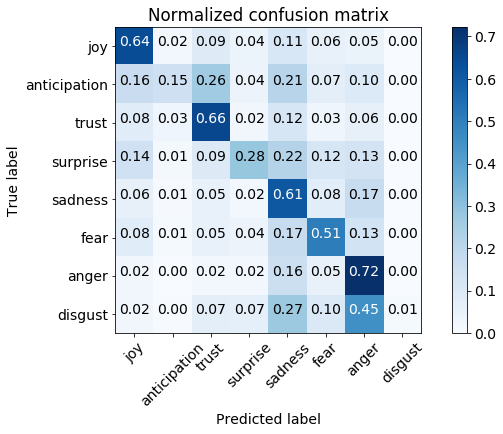

2018-01-03 22:05:34 -   2 epoch, loss:1.149/1.189, accuracy:0.595/0.581, f1-score:0.581/0.568, test acc:0.300
              precision    recall  f1-score   support

         joy       0.59      0.73      0.65     35117
anticipation       0.42      0.13      0.19      8660
       trust       0.59      0.64      0.61     22059
    surprise       0.48      0.30      0.37     16533
     sadness       0.56      0.62      0.59     44033
        fear       0.58      0.58      0.58     35158
       anger       0.65      0.63      0.64     33230
     disgust       0.36      0.01      0.03      1797

 avg / total       0.57      0.58      0.57    196587

Normalized confusion matrix


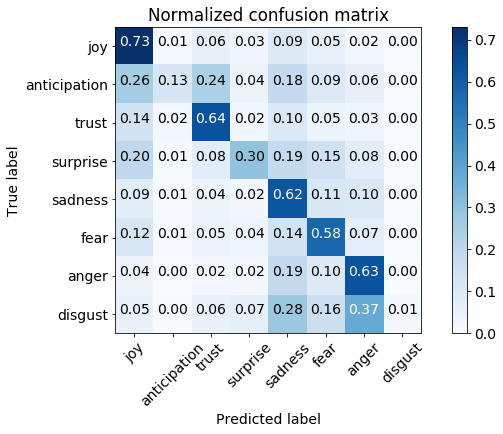

2018-01-03 22:09:07 -   3 epoch, loss:1.135/1.185, accuracy:0.600/0.585, f1-score:0.585/0.569, test acc:0.273
              precision    recall  f1-score   support

         joy       0.61      0.72      0.66     35123
anticipation       0.41      0.14      0.21      8661
       trust       0.54      0.70      0.61     22059
    surprise       0.56      0.24      0.34     16534
     sadness       0.58      0.60      0.59     44031
        fear       0.57      0.60      0.58     35155
       anger       0.64      0.66      0.65     33226
     disgust       0.30      0.01      0.02      1798

 avg / total       0.58      0.58      0.57    196587

Normalized confusion matrix


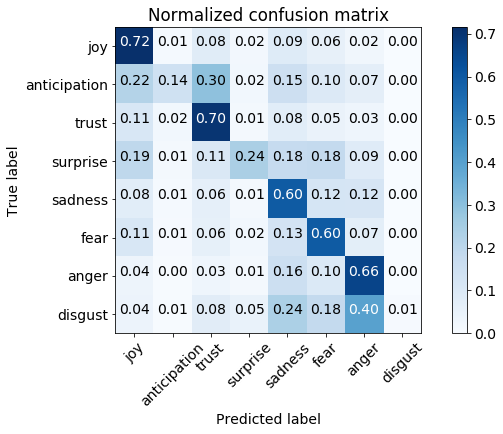

2018-01-03 22:12:35 -   4 epoch, loss:1.123/1.183, accuracy:0.605/0.586, f1-score:0.590/0.571, test acc:0.274
              precision    recall  f1-score   support

         joy       0.66      0.67      0.66     35125
anticipation       0.48      0.12      0.19      8659
       trust       0.55      0.70      0.61     22059
    surprise       0.52      0.28      0.37     16528
     sadness       0.58      0.58      0.58     44032
        fear       0.58      0.61      0.59     35156
       anger       0.59      0.72      0.64     33230
     disgust       0.28      0.01      0.01      1798

 avg / total       0.58      0.59      0.57    196587

Normalized confusion matrix


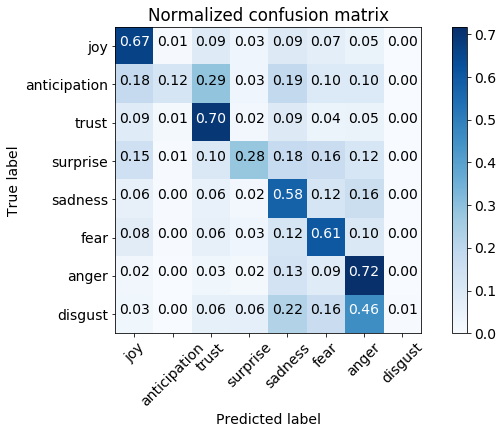

2018-01-03 22:16:08 -   5 epoch, loss:1.127/1.196, accuracy:0.606/0.584, f1-score:0.595/0.573, test acc:0.268
              precision    recall  f1-score   support

         joy       0.64      0.68      0.66     35123
anticipation       0.35      0.20      0.25      8661
       trust       0.48      0.75      0.58     22060
    surprise       0.54      0.27      0.36     16533
     sadness       0.58      0.60      0.59     44028
        fear       0.62      0.56      0.59     35159
       anger       0.64      0.66      0.65     33224
     disgust       0.36      0.01      0.02      1799

 avg / total       0.58      0.58      0.57    196587

Normalized confusion matrix


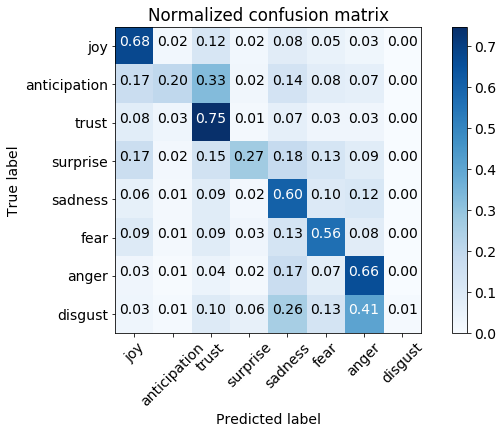

/home/yenhao/Documents/chatbot/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yenhao/Documents/chatbot/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


2018-01-03 22:19:35 -   6 epoch, loss:1.089/1.167, accuracy:0.619/0.593, f1-score:0.606/0.580, test acc:0.302
              precision    recall  f1-score   support

         joy       0.61      0.73      0.66     35128
anticipation       0.42      0.15      0.22      8659
       trust       0.57      0.66      0.62     22060
    surprise       0.51      0.31      0.39     16530
     sadness       0.57      0.62      0.60     44030
        fear       0.61      0.58      0.60     35159
       anger       0.64      0.66      0.65     33223
     disgust       0.00      0.00      0.00      1798

 avg / total       0.58      0.59      0.58    196587

Normalized confusion matrix


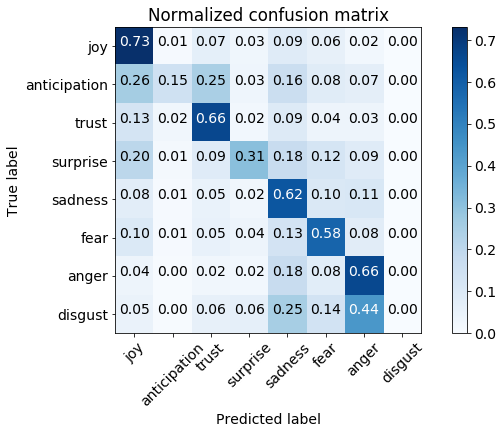

2018-01-03 22:23:03 -   7 epoch, loss:1.099/1.182, accuracy:0.614/0.588, f1-score:0.600/0.574, test acc:0.287
              precision    recall  f1-score   support

         joy       0.64      0.69      0.66     35122
anticipation       0.48      0.10      0.17      8661
       trust       0.54      0.70      0.61     22057
    surprise       0.48      0.33      0.39     16528
     sadness       0.52      0.71      0.60     44035
        fear       0.71      0.48      0.57     35159
       anger       0.65      0.64      0.64     33226
     disgust       0.12      0.00      0.00      1799

 avg / total       0.59      0.59      0.57    196587

Normalized confusion matrix


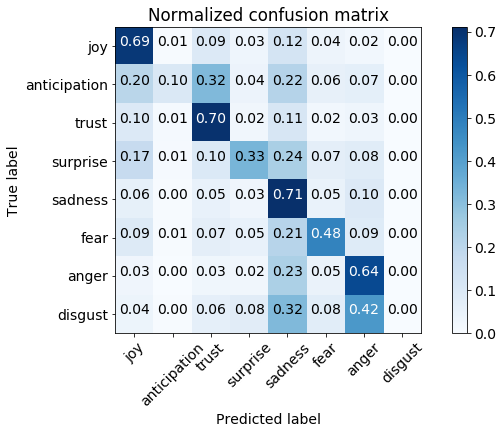

2018-01-03 22:26:30 -   8 epoch, loss:1.091/1.183, accuracy:0.619/0.590, f1-score:0.607/0.578, test acc:0.321
              precision    recall  f1-score   support

         joy       0.54      0.80      0.65     35124
anticipation       0.44      0.15      0.22      8662
       trust       0.67      0.59      0.62     22059
    surprise       0.47      0.34      0.39     16533
     sadness       0.59      0.60      0.60     44026
        fear       0.61      0.58      0.59     35159
       anger       0.65      0.64      0.65     33225
     disgust       0.29      0.01      0.03      1799

 avg / total       0.59      0.59      0.58    196587

Normalized confusion matrix


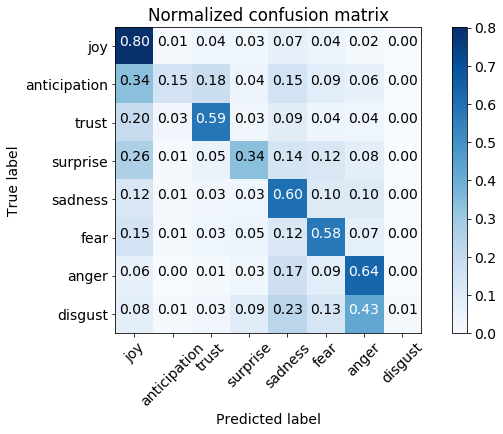

2018-01-03 22:29:56 -   9 epoch, loss:1.066/1.159, accuracy:0.628/0.595, f1-score:0.615/0.581, test acc:0.299
              precision    recall  f1-score   support

         joy       0.59      0.75      0.66     35122
anticipation       0.48      0.11      0.18      8658
       trust       0.62      0.63      0.62     22062
    surprise       0.47      0.35      0.40     16530
     sadness       0.58      0.62      0.60     44030
        fear       0.61      0.59      0.60     35163
       anger       0.65      0.66      0.65     33226
     disgust       0.40      0.00      0.00      1796

 avg / total       0.59      0.59      0.58    196587

Normalized confusion matrix


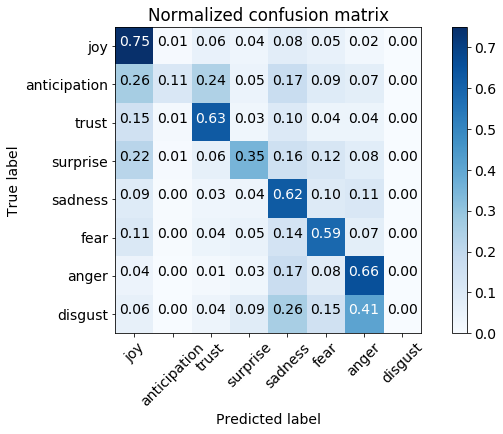

2018-01-03 22:33:24 -  10 epoch, loss:1.058/1.155, accuracy:0.630/0.597, f1-score:0.618/0.584, test acc:0.293
              precision    recall  f1-score   support

         joy       0.63      0.71      0.67     35117
anticipation       0.42      0.16      0.23      8662
       trust       0.60      0.64      0.62     22058
    surprise       0.53      0.31      0.39     16533
     sadness       0.54      0.69      0.60     44034
        fear       0.65      0.57      0.60     35157
       anger       0.65      0.65      0.65     33228
     disgust       0.33      0.00      0.00      1798

 avg / total       0.59      0.60      0.58    196587

Normalized confusion matrix


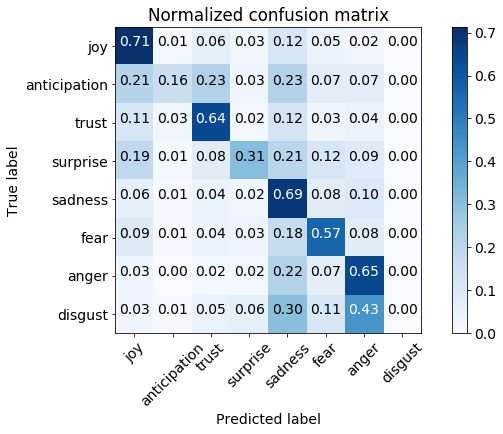

2018-01-03 22:36:52 -  11 epoch, loss:1.056/1.156, accuracy:0.632/0.598, f1-score:0.620/0.586, test acc:0.297
              precision    recall  f1-score   support

         joy       0.60      0.74      0.66     35115
anticipation       0.44      0.17      0.24      8661
       trust       0.64      0.63      0.63     22061
    surprise       0.50      0.32      0.39     16532
     sadness       0.55      0.67      0.60     44026
        fear       0.64      0.57      0.60     35159
       anger       0.66      0.65      0.65     33234
     disgust       0.36      0.01      0.01      1799

 avg / total       0.59      0.60      0.59    196587

Normalized confusion matrix


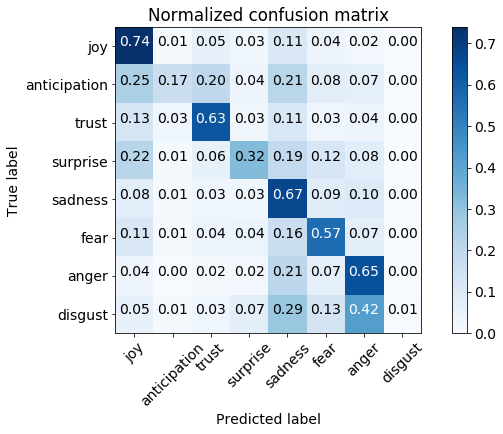

2018-01-03 22:40:19 -  12 epoch, loss:1.052/1.157, accuracy:0.633/0.596, f1-score:0.622/0.585, test acc:0.297
              precision    recall  f1-score   support

         joy       0.61      0.72      0.66     35120
anticipation       0.51      0.12      0.19      8661
       trust       0.67      0.60      0.63     22059
    surprise       0.42      0.42      0.42     16533
     sadness       0.57      0.63      0.60     44030
        fear       0.62      0.58      0.60     35156
       anger       0.64      0.67      0.65     33229
     disgust       0.24      0.00      0.01      1799

 avg / total       0.59      0.60      0.59    196587

Normalized confusion matrix


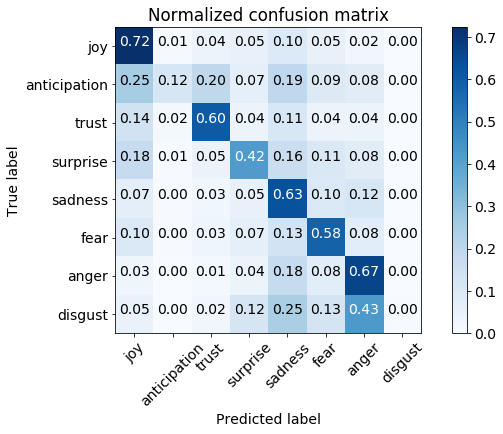

2018-01-03 22:43:47 -  13 epoch, loss:1.053/1.162, accuracy:0.633/0.596, f1-score:0.619/0.582, test acc:0.301
              precision    recall  f1-score   support

         joy       0.57      0.77      0.66     35116
anticipation       0.55      0.09      0.16      8659
       trust       0.68      0.60      0.64     22058
    surprise       0.48      0.36      0.41     16535
     sadness       0.54      0.68      0.61     44032
        fear       0.62      0.59      0.61     35157
       anger       0.71      0.58      0.64     33231
     disgust       0.00      0.00      0.00      1799

 avg / total       0.60      0.60      0.58    196587

Normalized confusion matrix


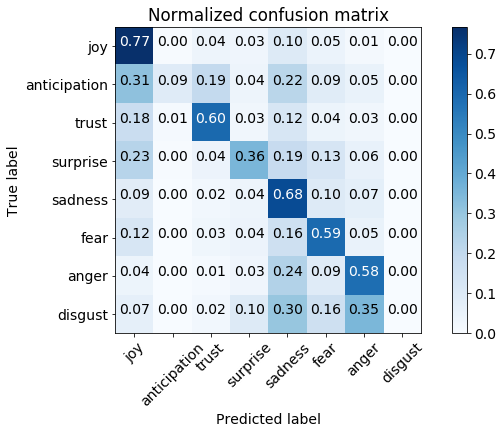

2018-01-03 22:47:13 -  14 epoch, loss:1.038/1.158, accuracy:0.638/0.598, f1-score:0.626/0.585, test acc:0.299
              precision    recall  f1-score   support

         joy       0.63      0.71      0.66     35121
anticipation       0.48      0.13      0.20      8662
       trust       0.60      0.66      0.63     22065
    surprise       0.48      0.37      0.42     16532
     sadness       0.60      0.59      0.60     44024
        fear       0.60      0.61      0.60     35160
       anger       0.61      0.70      0.65     33225
     disgust       0.00      0.00      0.00      1798

 avg / total       0.58      0.60      0.59    196587

Normalized confusion matrix


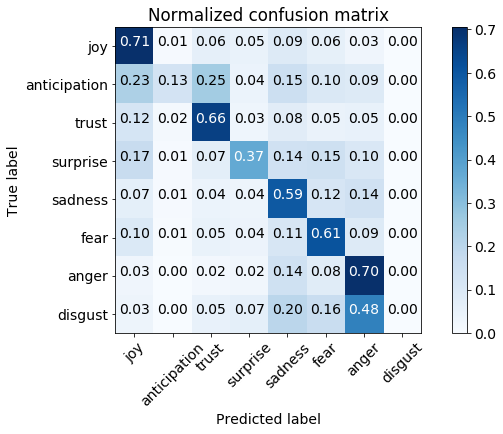

2018-01-03 22:50:41 -  15 epoch, loss:1.040/1.164, accuracy:0.635/0.595, f1-score:0.625/0.584, test acc:0.290
              precision    recall  f1-score   support

         joy       0.65      0.68      0.67     35119
anticipation       0.39      0.18      0.25      8659
       trust       0.54      0.71      0.61     22061
    surprise       0.50      0.34      0.41     16528
     sadness       0.62      0.56      0.59     44033
        fear       0.62      0.60      0.61     35161
       anger       0.58      0.73      0.65     33227
     disgust       0.00      0.00      0.00      1799

 avg / total       0.59      0.60      0.58    196587

Normalized confusion matrix


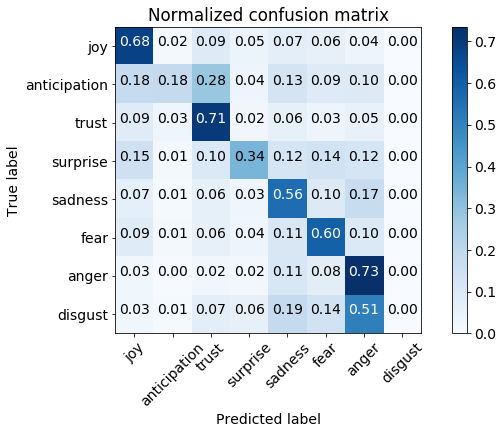

2018-01-03 22:54:08 -  16 epoch, loss:1.049/1.176, accuracy:0.633/0.590, f1-score:0.620/0.577, test acc:0.272
              precision    recall  f1-score   support

         joy       0.64      0.69      0.67     35123
anticipation       0.47      0.12      0.19      8657
       trust       0.58      0.68      0.62     22060
    surprise       0.53      0.31      0.39     16534
     sadness       0.61      0.57      0.59     44028
        fear       0.51      0.70      0.59     35162
       anger       0.67      0.63      0.65     33225
     disgust       0.52      0.01      0.01      1798

 avg / total       0.59      0.59      0.58    196587

Normalized confusion matrix


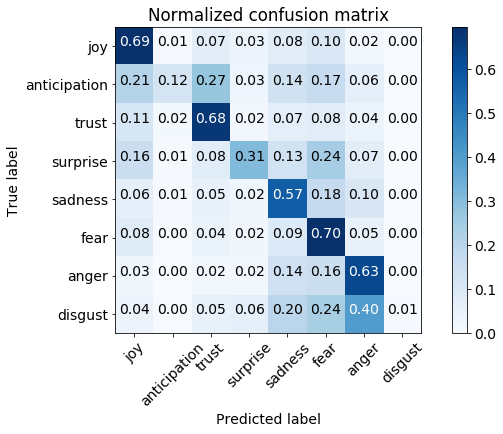

2018-01-03 22:57:34 -  17 epoch, loss:1.038/1.172, accuracy:0.635/0.592, f1-score:0.624/0.581, test acc:0.290
              precision    recall  f1-score   support

         joy       0.64      0.69      0.66     35125
anticipation       0.50      0.11      0.18      8657
       trust       0.56      0.70      0.62     22060
    surprise       0.42      0.44      0.43     16531
     sadness       0.62      0.56      0.59     44031
        fear       0.62      0.58      0.60     35158
       anger       0.61      0.71      0.66     33226
     disgust       0.50      0.00      0.01      1799

 avg / total       0.59      0.59      0.58    196587

Normalized confusion matrix


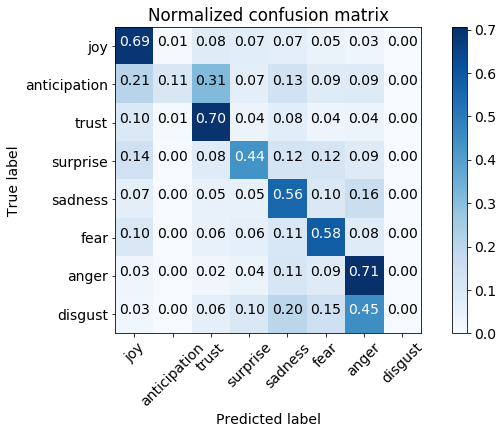

2018-01-03 23:01:02 -  18 epoch, loss:1.032/1.165, accuracy:0.641/0.598, f1-score:0.629/0.586, test acc:0.270
              precision    recall  f1-score   support

         joy       0.65      0.68      0.67     35117
anticipation       0.41      0.17      0.24      8661
       trust       0.62      0.63      0.63     22064
    surprise       0.57      0.29      0.38     16528
     sadness       0.53      0.71      0.61     44027
        fear       0.60      0.61      0.60     35165
       anger       0.67      0.63      0.65     33229
     disgust       0.32      0.04      0.07      1796

 avg / total       0.60      0.60      0.59    196587

Normalized confusion matrix


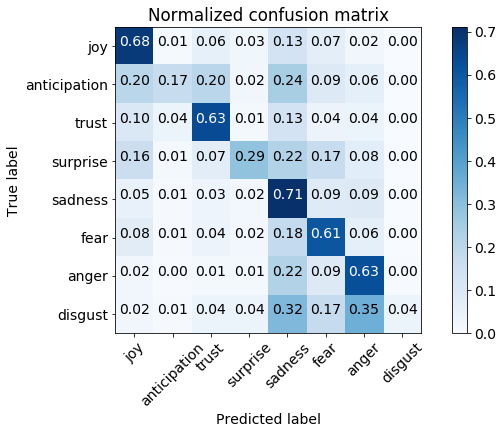

2018-01-03 23:04:36 -  19 epoch, loss:1.043/1.172, accuracy:0.633/0.590, f1-score:0.621/0.578, test acc:0.298
              precision    recall  f1-score   support

         joy       0.57      0.76      0.66     35120
anticipation       0.39      0.19      0.25      8660
       trust       0.64      0.63      0.63     22060
    surprise       0.57      0.27      0.37     16531
     sadness       0.55      0.69      0.61     44030
        fear       0.58      0.61      0.59     35157
       anger       0.76      0.52      0.61     33231
     disgust       0.37      0.04      0.08      1798

 avg / total       0.60      0.59      0.58    196587

Normalized confusion matrix


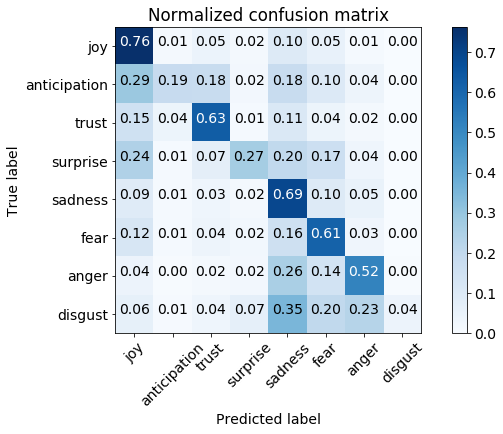

In [ ]:
round_of_epochs = int(tweets_train.shape[0]/batch_size)
valid_round_of_epochs = int(tweets_valid.shape[0]/batch_size)

train_loss = []
valid_loss = []
test_loss  = []

train_f1 = []
valid_f1 = []
test_f1 = []
x_axis = np.arange(1., epochs_num, 1)
saver = tf.train.Saver() # to store the model

best_valid_acc = 0

testing_res = []
with tf.Session() as sess:
    # Initialize all variables
#     if os.path.exists('./model/emo_504.ckpt.meta'):
#         print ("Model Restore")
#         saver.restore(sess, './model/emo_504.ckpt')
#     else:
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(word2vec.assign(distance_supervised_embeddings))# Assign the pretrain word2vec
    
    for epochs in range(epochs_num): # starting the training process and set the epochs_num
        for _ in range(round_of_epochs):
#             train, label = sess.run(train_next_batch) # Get the mini-batch data sample from tensorflow
            train, label = next(iter_) # Get the mini-batch data sample from tensorflow

#             sess.run(train_step, feed_dict={X:train, y:label, mode:True}) # Feed the features, labe, training_mode  to network to train
            sess.run([train_step, cross_entropy, predicted_class, accuracy], feed_dict={X:train, y:label, mode:True}) # Feed the features, labe, training_mode  to network to train
    
        # An epoch finish
        
        # Training evaluation
        train_res_loss, train_res_f1, train_res_acc, _ = training_evaluation(sess, iter_, round_of_epochs)
        
        # Validation evaluation
        valid_res_loss, valid_res_f1, valid_res_acc, pred_label  = training_evaluation(sess, valid_iter_, valid_round_of_epochs)

        train_loss.append(train_res_loss)
        valid_loss.append(valid_res_loss)
        train_f1.append(train_res_f1)
        valid_f1.append(valid_res_f1)
        
        test_pred, test_acc = sess.run([predicted_class, accuracy], feed_dict={X:tweets_test, y:senti_test, mode:False})
        testing_res.append(test_pred)
        
        print("{} - {:3d} epoch, loss:{:.3f}/{:.3f}, accuracy:{:.3f}/{:.3f}, f1-score:{:.3f}/{:.3f}, test acc:{:.3f}".format(
            datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            epochs+1,
            train_res_loss, 
            valid_res_loss,
            train_res_acc,
            valid_res_acc,
            train_res_f1,
            valid_res_f1,
            test_acc
            )
        )
        classification_report_confusion_matrix(pred_label)
        
        
        if best_valid_acc < valid_res_f1:
            best_valid_acc = valid_res_f1
            save_path = saver.save(sess, "./model/emo_"+str(valid_res_f1)[2:5]+".ckpt")
        
    plt.rcParams['font.size'] = 14
    plt.plot(x_axis, train_loss, 'r', x_axis, valid_loss, 'b')
    plt.legend(['Train', 'Valid'], loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Loss(cross entropy)')
    plt.show()
    plt.clf()
    plt.plot(x_axis, train_f1, x_axis, valid_f1)
    plt.legend(['Train', 'Valid'], loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.show()

    

In [ ]:
round_of_epochs = int(tweets_train.shape[0]/batch_size)
valid_round_of_epochs = int(tweets_valid.shape[0]/batch_size)

train_loss = []
valid_loss = []
test_loss  = []

train_f1 = []
valid_f1 = []
test_f1 = []
x_axis = np.arange(1., epochs_num, 1)
saver = tf.train.Saver() # to store the model

best_valid_acc = 0

testing_res = []
with tf.Session() as sess:
    # Initialize all variables
#     if os.path.exists('./model/emo_504.ckpt.meta'):
#         print ("Model Restore")
#         saver.restore(sess, './model/emo_504.ckpt')
#     else:
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(word2vec.assign(distance_supervised_embeddings))# Assign the pretrain word2vec
#     print(round_of_epochs)
    for epochs in range(epochs_num): # starting the training process and set the epochs_num
        for _ in range(round_of_epochs):
#             train, label = sess.run(train_next_batch) # Get the mini-batch data sample from tensorflow
            train, label = next(iter_) # Get the mini-batch data sample from tensorflow

            sess.run(train_step, feed_dict={X:train, y:label, mode:True}) # Feed the features, labe, training_mode  to network to train

        # An epoch finish
        
        # Training evaluation
#         print("Train eval")
        train_res_loss, train_res_f1, train_res_acc, _ = training_evaluation(sess, iter_, round_of_epochs)
        
        # Validation evaluation
#         print("Validation eval")
        valid_res_loss, valid_res_f1, valid_res_acc, pred_label = training_evaluation(sess, valid_iter_, valid_round_of_epochs)

        train_loss.append(train_res_loss)
        valid_loss.append(valid_res_loss)
        train_f1.append(train_res_f1)
        valid_f1.append(valid_res_f1)
        
        test_pred, test_acc = sess.run([predicted_class, accuracy], feed_dict={X:tweets_test, y:senti_test, mode:False})
        testing_res.append(test_pred)
        
        print("{} - {:3d} epoch, loss:{:.3f}/{:.3f}, accuracy:{:.3f}/{:.3f}, f1-score:{:.3f}/{:.3f}, test acc:{:.3f}".format(
            datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            epochs+1,
            train_res_loss, 
            valid_res_loss,
            train_res_acc,
            valid_res_acc,
            train_res_f1,
            valid_res_f1,
            test_acc
            )
        )
        classification_report_confusion_matrix(pred_label)
        
        if best_valid_acc < valid_res_f1:
            best_valid_acc = valid_res_f1
            save_path = saver.save(sess, "./model/word_eng/emo_"+str(valid_res_f1)[2:5]+".ckpt")
        
    plt.rcParams['font.size'] = 14
    plt.plot(x_axis, train_loss, 'r', x_axis, valid_loss, 'b')
    plt.legend(['Train', 'Valid'], loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Loss(cross entropy)')
    plt.show()
    plt.clf()
    plt.plot(x_axis, train_f1, x_axis, valid_f1)
    plt.legend(['Train', 'Valid'], loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.show()

    

In [235]:
# restore graph
restore_saver = tf.train.import_meta_graph('./model/emo_504.ckpt.meta')

with tf.Session() as sess:
    
    saver.restore(sess, tf.train.latest_checkpoint('./model/'))
#     saver.restore(sess, './model/emo_504.ckpt.meta')
    sess.run(tf.global_variables_initializer())
#     sess.run(word2vec.assign(distance_supervised_embeddings))# Assign the pretrain word2vec
    # input the testing tweets
    

## 

# Testing Evalution

In [130]:
from sklearn.metrics import confusion_matrix
import itertools

In [131]:
def label2emotion(label):
    if label == 0:            return 'joy'
    elif label == 1: return 'anticipation'
    elif label == 2:        return 'trust'
    elif label == 3:     return 'surprise'
    elif label == 4:      return 'sadness'
    elif label == 5:         return 'fear'
    elif label == 6:        return 'anger'
    elif label == 7:      return 'disgust'

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [135]:
testing_res[2]

array([1, 2, 2, ..., 0, 5, 5], dtype=int32)

In [145]:
eva_res = pd.DataFrame({'pred':testing_res[2]})

In [27]:
eva_res['emotion'] = eva_res['pred'].map(label2emotion)

In [28]:
class_names = ['joy','anticipation','trust','surprise','sadness','fear','anger','disgust']
cfm = confusion_matrix(en_test.emotion, eva_res.emotion, labels=class_names)

In [29]:
print(classification_report(en_test.emotion, eva_res.emotion, target_names=class_names))

              precision    recall  f1-score   support

         joy       0.36      0.37      0.37       223
anticipation       0.00      0.00      0.00       272
       trust       0.00      0.00      0.00       183
    surprise       0.12      0.36      0.18       119
     sadness       0.61      0.55      0.58       591
        fear       0.21      0.68      0.33       218
       anger       0.00      0.00      0.00       246
     disgust       0.30      0.40      0.34       102

 avg / total       0.27      0.33      0.28      1954



/home/yenhao/Documents/chatbot/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [151]:
def classification_report_confusion_matrix(pred_label, class_names = ['joy','anticipation','trust','surprise','sadness','fear','anger','disgust']):
   
    print(classification_report(pred_label[1], pred_label[0], target_names=class_names))

    pred_res_pd = pd.DataFrame({'pred':pred_label[0], 'label':pred_label[1]})
    cfm = confusion_matrix(y_pred=pred_res_pd.pred.map(label2emotion), y_true=pred_res_pd.label.map(label2emotion), labels=class_names)
    plt.figure(figsize=(9,6))
    plot_confusion_matrix(cfm, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')
    plt.show()

              precision    recall  f1-score   support

         joy       0.63      0.74      0.68     35122
anticipation       0.45      0.14      0.22      8659
       trust       0.60      0.70      0.65     22060
    surprise       0.53      0.36      0.43     16530
     sadness       0.59      0.66      0.62     44029
        fear       0.55      0.66      0.60     35160
       anger       0.75      0.56      0.64     33228
     disgust       0.71      0.01      0.01      1799

 avg / total       0.61      0.61      0.59    196587

Normalized confusion matrix


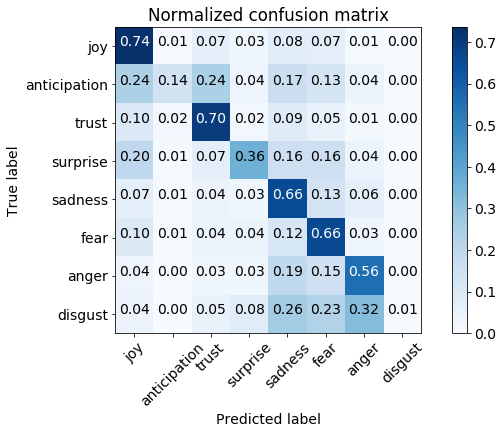

In [152]:
classification_report_confusion_matrix(pred_label)

Normalized confusion matrix


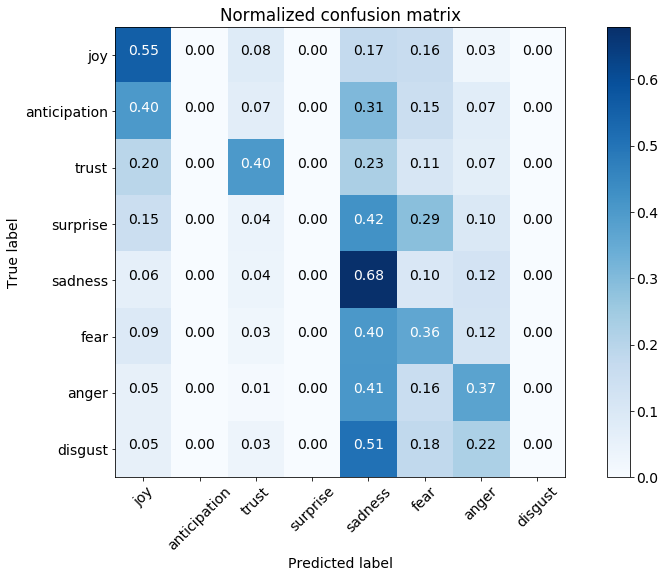

In [30]:

# Plot non-normalized confusion matrix
# plt.figure(figsize=(12,8))
# plot_confusion_matrix(cfm, classes=class_names,
#                       title='Confusion matrix, without normalization')
# plt.show()
# Plot normalized confusion matrix
plt.figure(figsize=(12,8))
plot_confusion_matrix(cfm, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [31]:
emo_eval_dict = {'joy':         0,
                 'surprise':    0,
                 'trust':       0,
                 'anticipation':0,
                 'fear':        0,
                 'sadness':     0,
                 'disgust':     0,
                 'anger':       0
                 }

emo_total_dict = {'joy':         0,
                  'surprise':    0,
                  'trust':       0,
                  'anticipation':0,
                  'fear':        0,
                  'sadness':     0,
                  'disgust':     0,
                  'anger':       0
                  }

In [32]:
correct = 0
first_correct = 0
emo_first_correct_dict = dict(emo_eval_dict)
emo_correct_dict = dict(emo_eval_dict)
for i, emo in enumerate(eva_res['emotion']):
    emo_total_dict[emo] += 1
    if emo == en_test.emotion[i]:
        first_correct += 1
        emo_first_correct_dict[emo] += 1
        correct += 1
        emo_correct_dict[emo] +=1
    elif emo == en_test.emotion2[i]:
        correct += 1
        emo_correct_dict[emo] +=1

In [33]:
correct/eva_res.shape[0]

0.43654042988741043

## Parallen N-gram CNN

In [35]:
num_filters = 300
pooling_strides = 1

reset_graph()

X = tf.placeholder(tf.int32, shape = (None, n_input), name = "Input_X")
y = tf.placeholder(tf.int32, shape = (None), name = "Y")
mode = tf.placeholder(tf.bool, name = "Mode")

# Load Embedding Model
with tf.device('/cpu:0'), tf.name_scope("embedding"):
    word2vec = tf.Variable(tf.constant(0.0, shape = multi_embeddings.shape),
                    trainable=False, name="word2vec") # trainable=False, means not update these embeddings

embedded_chars = tf.nn.embedding_lookup(word2vec, X)
# embedded_chars_expanded = tf.expand_dims(embedded_chars, -1) # ex: convert [[1,2]] to [[1],[2]], that is shape (2,) to (2,1)

# 1st convolution layer
conv11 = tf.layers.conv2d(embedded_chars, 
                         filters = num_filters, 
                         kernel_size = (3, distance_supervised_embeddings.shape[1]),
                         strides = (1,1), 
                         kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                         activation = tf.nn.relu,
                         name="Convolution_1st"
                        )

pool11 = tf.layers.max_pooling2d(inputs=conv11, pool_size=[pooling_size, 1], strides=pooling_strides)

# 2nd convolution layer
conv21 = tf.layers.conv2d(pool11, 
                         filters = num_filters, 
                         kernel_size = (filter_sizes[1], 1),
                         strides = (1,1), 
                         padding="same",
                         kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                         activation = tf.nn.relu,
                         name="Convolution_2nd"
                        )
print(conv21.shape)
pool21 = tf.layers.max_pooling2d(inputs=conv21, pool_size=[56, 1], strides=1)

# Dense Layer, Combine all the pooled features
# pool21_flat = tf.reshape(pool21, [-1, num_filters])

# 1st convolution layer
conv12 = tf.layers.conv2d(embedded_chars, 
                         filters = num_filters, 
                         kernel_size = (4, distance_supervised_embeddings.shape[1]),
                         strides = (1,1), 
                         kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                         activation = tf.nn.relu,
                         name="Convolution_1st_2"
                        )

pool12 = tf.layers.max_pooling2d(inputs=conv12, pool_size=[pooling_size, 1], strides=pooling_strides)

# 2nd convolution layer
conv22 = tf.layers.conv2d(pool12, 
                         filters = num_filters, 
                         kernel_size = (filter_sizes[1], 1),
                         strides = (1,1),
                         kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                         activation = tf.nn.relu,
                         name="Convolution_2nd_2"
                        )
print(conv22.shape)
pool22 = tf.layers.max_pooling2d(inputs=conv22, pool_size=[53, 1], strides=1)

# Dense Layer, Combine all the pooled features
# pool22_flat = tf.reshape(pool22, [-1, num_filters])

# 1st convolution layer
conv13 = tf.layers.conv2d(embedded_chars, 
                         filters = num_filters, 
                         kernel_size = (5, distance_supervised_embeddings.shape[1]),
                         strides = (1,1), 
                         kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                         activation = tf.nn.relu,
                         name="Convolution_1st_3"
                        )

pool13 = tf.layers.max_pooling2d(inputs=conv13, pool_size=[pooling_size, 1], strides=pooling_strides)

# 2nd convolution layer
conv23 = tf.layers.conv2d(pool13, 
                         filters = num_filters, 
                         kernel_size = (filter_sizes[1], 1),
                         strides = (1,1),
                         kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                         activation = tf.nn.relu,
                         name="Convolution_2nd_3"
                        )
print(conv23.shape)
pool23 = tf.layers.max_pooling2d(inputs=conv23, pool_size=[50, 1], strides=1)

print(pool23.shape)

# Dense Layer, Combine all the pooled features
# pool23_flat = tf.reshape(pool23, [-1, num_filters])

# print(pool21_flat.shape)
# print(pool22_flat.shape)
# print(pool23_flat.shape)

# conv_concat = tf.concat([pool21_flat, pool22_flat, pool23_flat], 1)

conv_concat = tf.concat([pool21, pool22, pool23], 1)

print(conv_concat.shape)

conv_concat = tf.reshape(conv_concat, [-1, 5*num_filters])

print(conv_concat.shape)

dense = tf.layers.dropout(inputs = conv_concat, rate = 0.3, training = mode)

dense = tf.layers.dense(inputs=dense, units=1024, activation=tf.nn.relu, name = "Fully_connect")


# Logits Layer
logits = tf.layers.dense(inputs=dense, 
                         units=n_output, 
                         activation=tf.nn.softmax, 
#                          kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                         name = "Softmax")

# Define Loss Function
cross_entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits, name="Cross_Entropy"))

# Define Training Process
train_step = tf.train.AdadeltaOptimizer(learning_rate, epsilon=1e-6).minimize(cross_entropy)

# Define Accuracy
predicted_class = tf.argmax(logits,1, output_type=tf.int32)
correct_predict = tf.equal(y, predicted_class) # [True, False ..., True]
accuracy = tf.reduce_mean(tf.cast(correct_predict, tf.float32)) # [True, False ..., True] --> [1,0,...,1]


(?, 56, 1, 300)
(?, 53, 1, 300)
(?, 52, 1, 300)
(?, 3, 1, 300)
(?, 5, 1, 300)
(?, 1500)


In [36]:
with tf.Session() as sess:
    show_graph(tf.get_default_graph().as_graph_def())
    # Initialize all variables
#     sess.run(tf.local_variables_initializer())
#     sess.run(tf.global_variables_initializer())
    
#     sess.run(word2vec.assign(initW))# Assign the pretrain word2vec


/home/yenhao/Documents/chatbot/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


2017-12-19 15:22:55 -   1 epoch,     1 round, loss:2.096, acc:0.059/0.082, f1:0.044/0.065, test acc:0.157
2017-12-19 15:23:43 -   1 epoch,   501 round, loss:1.842, acc:0.422/0.425, f1:0.350/0.366, test acc:0.242
2017-12-19 15:24:30 -   1 epoch,  1001 round, loss:1.812, acc:0.449/0.457, f1:0.389/0.392, test acc:0.304
2017-12-19 15:25:18 -   1 epoch,  1501 round, loss:1.833, acc:0.438/0.463, f1:0.365/0.397, test acc:0.296
2017-12-19 15:26:06 -   1 epoch,  2001 round, loss:1.853, acc:0.418/0.460, f1:0.348/0.394, test acc:0.327
2017-12-19 15:26:53 -   1 epoch,  2501 round, loss:1.750, acc:0.516/0.501, f1:0.482/0.463, test acc:0.278
2017-12-19 15:27:41 -   1 epoch,  3001 round, loss:1.760, acc:0.500/0.510, f1:0.462/0.469, test acc:0.347
2017-12-19 15:28:29 -   1 epoch,  3501 round, loss:1.773, acc:0.496/0.518, f1:0.455/0.477, test acc:0.307
2017-12-19 15:29:16 -   1 epoch,  4001 round, loss:1.821, acc:0.449/0.521, f1:0.404/0.483, test acc:0.267
2017-12-19 15:30:04 -   1 epoch,  4501 round, 

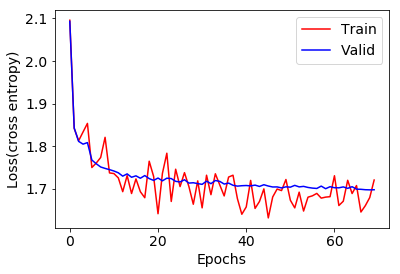

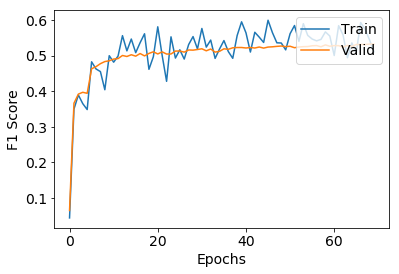

In [37]:
# prepare the training batch in python

def data_iterator(X, y):
    """ A simple data iterator """
    batch_idx = 0
    while True:
        for batch_idx in range(0, len(X), batch_size):
            trains_batch = X[batch_idx:batch_idx+batch_size]
            labels_batch = y[batch_idx:batch_idx+batch_size]
            yield trains_batch, labels_batch


iter_ = data_iterator(tweets_train, senti_train)

valid_iter_ = data_iterator(tweets_valid, senti_valid)
round_of_epochs = int(tweets_train.shape[0]/batch_size)
valid_rounds_of_epochs = int(tweets_valid.shape[0]/batch_size)

train_loss = []
test_loss  = []

train_f1 = []
test_f1 = []

saver = tf.train.Saver() # to store the model

best_valid_acc = 0

testing_res = []

validation_rounds = 0
epochs_num = 5
with tf.Session() as sess:
    # Initialize all variables
#     if os.path.exists('./model/emo_504.ckpt.meta'):
#         print ("Model Restore")
#         saver.restore(sess, './model/emo_504.ckpt')
#     else:
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(word2vec.assign(multi_embeddings))# Assign the pretrain word2vec
    
    for epochs in range(epochs_num): # starting the training process and set the epochs_num
        for roun in range(round_of_epochs):
#             train, label = sess.run(train_next_batch) # Get the mini-batch data sample from tensorflow
            train, label = next(iter_) # Get the mini-batch data sample from tensorflow

            if roun % 500 == 0: # go to validation
                validation_rounds +=1
                
                # Round finish
                loss, pred, acc = sess.run([cross_entropy, predicted_class, accuracy], feed_dict={X:train, y:label, mode:False})

                # Validation
                valid_loss_list = []
                predict_res = np.zeros(batch_size)
                t_label = np.zeros(batch_size)
                valid_acc_list = []
                for _ in range(valid_rounds_of_epochs):
                    x_valid, y_valid = next(valid_iter_) # Get the mini-batch data sample from tensorflow
                    t_loss, t_pred, t_accuracy = sess.run([cross_entropy, predicted_class, accuracy], feed_dict={X:x_valid, y:y_valid, mode:False})
                    valid_loss_list.append(t_loss)
                    predict_res = np.concatenate((predict_res, t_pred))
                    t_label = np.concatenate((t_label, y_valid))
                    valid_acc_list.append(t_accuracy)
                # An epoch finish
        #         t_loss, t_pred = sess.run([cross_entropy,predicted_class], feed_dict={X:tweets_valid, y:senti_valid})
                train_loss.append(loss)
                test_loss.append(sum(valid_loss_list)/len(valid_loss_list))
                train_f1.append(f1_score(label, pred, average='weighted'))
                test_f1.append(f1_score(t_label[1:], predict_res[1:], average='weighted'))

                t_acc = sum(valid_acc_list)/len(valid_acc_list)

                test_pred, test_acc = sess.run([predicted_class, accuracy], feed_dict={X:tweets_test, y:senti_test, mode:False})
                print("{} - {:3d} epoch, {:5d} round, loss:{:.3f}, acc:{:.3f}/{:.3f}, f1:{:.3f}/{:.3f}, test acc:{:.3f}".format(
                    datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                    epochs+1,
                    roun+1,
                    loss, 
                    acc,
                    t_acc,
                    f1_score(label, pred, average='weighted'),
                    f1_score(t_label[1:], predict_res[1:], average='weighted'),
                    test_acc
                    )
                )
                testing_res.append(test_pred)
            # Train
            sess.run(train_step, feed_dict={X:train, y:label, mode:True}) # Feed the features, labe, training_mode  to network to train  
        
#         if best_valid_acc < t_acc:
#             best_valid_acc = t_acc
#             save_path = saver.save(sess, "./model/emo_"+str(t_acc)[2:5]+".ckpt")
    
    x_axis = np.arange(0., validation_rounds, 1)
    plt.rcParams['font.size'] = 14
    plt.plot(x_axis, train_loss, 'r', x_axis, test_loss, 'b')
    plt.legend(['Train', 'Valid'], loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Loss(cross entropy)')
    plt.show()
    plt.clf()
    plt.plot(x_axis, train_f1, x_axis, test_f1)
    plt.legend(['Train', 'Valid'], loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.show()

    

Normalized confusion matrix


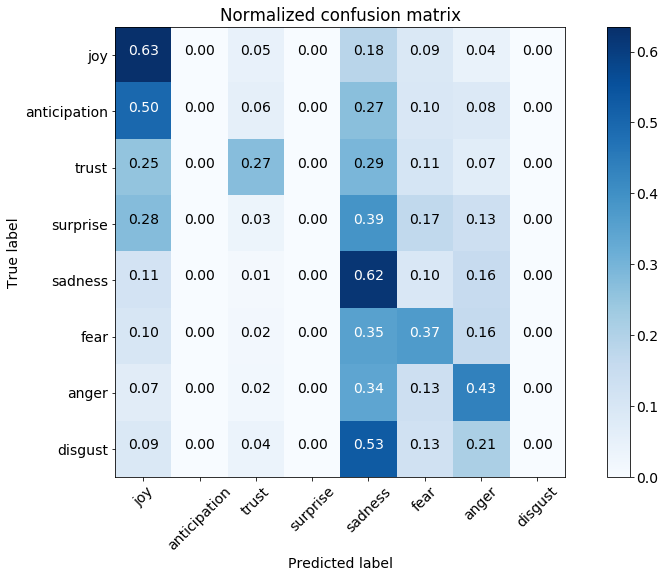

In [38]:
eva_res = pd.DataFrame({'pred':testing_res[6]})
eva_res['emotion'] = eva_res['pred'].map(label2emotion)
cfm = confusion_matrix(en_test.emotion, eva_res.emotion, labels=class_names)
plt.figure(figsize=(12,8))
plot_confusion_matrix(cfm, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

Normalized confusion matrix


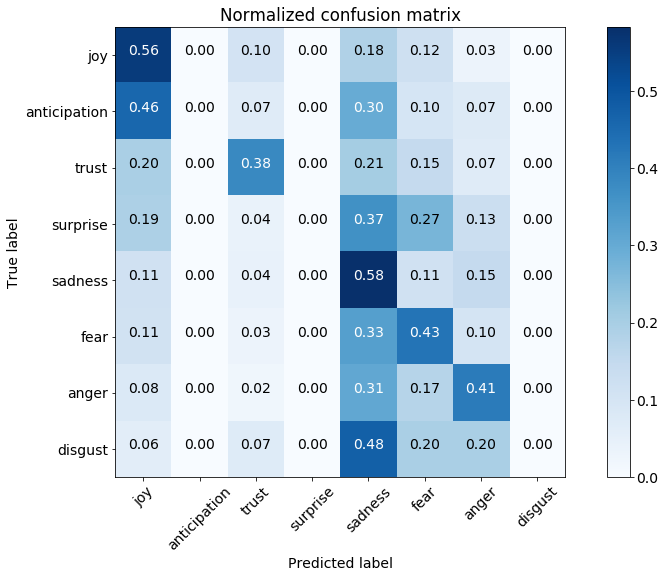

In [39]:
eva_res = pd.DataFrame({'pred':testing_res[52]})
eva_res['emotion'] = eva_res['pred'].map(label2emotion)
cfm = confusion_matrix(en_test.emotion, eva_res.emotion, labels=class_names)
plt.figure(figsize=(12,8))
plot_confusion_matrix(cfm, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()